In [102]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import duckdb
import autogluon as ag
import seaborn as sns

In [103]:
query = """
SELECT count(*) AS atendimentos, aei.ano, aei.mes,
FROM main.atendimentos_em_ijui aei
GROUP BY aei.ano, aei.mes
"""
"""
SELECT count(*) AS atendimentos, aei.ano, aei.mes, aei.racacor, aei.sexo, aei.Motivo_saida_permanencia, aei.cidpri, 
FROM main.atendimentos_em_ijui aei
GROUP BY aei.ano, aei.mes, aei.racacor, aei.sexo, aei. Motivo_saida_permanencia, aei.cidpri
"""

database = duckdb.connect("database/database_pi.db")
rows = database.query(query).fetchall()
database.close()

dataframe = pd.DataFrame(rows)
dataframe.columns = ["atendimentos","Year","Month"]
                     #,"racacor","sexo","Motivo_saida_permanencia","cidpri"]

# data = dataframe.dropna()
data = dataframe
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(Day=1))
# data['YearMonth'] = data['Date'].dt.to_period('M')

data = data.drop(labels=['Year','Month'], axis=1)
print(data)

    atendimentos       Date
0             12 2014-08-01
1             58 2014-09-01
2           4394 2014-10-01
3           4644 2014-11-01
4           4344 2014-12-01
..           ...        ...
85         10584 2023-08-01
86          8016 2023-09-01
87          7618 2023-10-01
88         10972 2023-11-01
89          9506 2023-12-01

[90 rows x 2 columns]


<Axes: xlabel='Date', ylabel='atendimentos'>

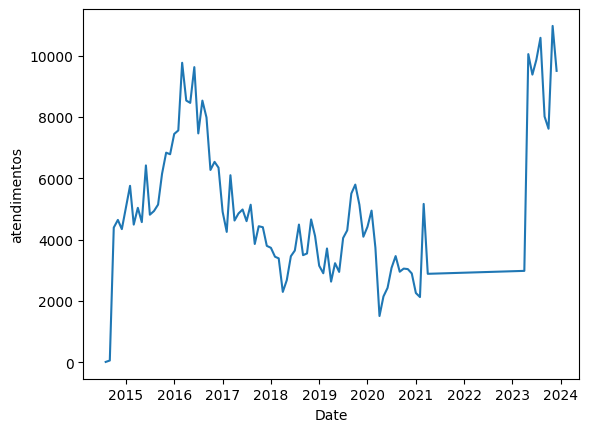

In [104]:
sns.lineplot(data=data, x="Date", y="atendimentos")

In [105]:
from autogluon.tabular import TabularDataset, TabularPredictor

data.sort_values(by="Date", inplace=True)
dataset = TabularDataset(data.head(int(len(data)/2)))

label = "atendimentos"
dataset.describe()

,atendimentos,Date
count,45.000000,45
mean,5396.488889,2016-05-31 21:52:00
min,12.000000,2014-08-01 00:00:00
25%,4406.000000,2015-07-01 00:00:00
50%,4984.000000,2016-06-01 00:00:00
75%,6538.000000,2017-05-01 00:00:00
max,9770.000000,2018-04-01 00:00:00
std,2067.851461,NaN


In [106]:
predictor = TabularPredictor(label=label).fit(dataset)

No path specified. Models will be saved in: "AutogluonModels/ag-20240615_004822"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240615_004822"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.11.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun May 26 20:05:41 UTC 2024
CP

In [107]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-643.993317,root_mean_squared_error,0.023798,0.600916,0.000261,0.010991,2,True,12
1,CatBoost,-697.994163,root_mean_squared_error,0.000993,0.161052,0.000993,0.161052,1,True,6
2,NeuralNetFastAI,-712.201960,root_mean_squared_error,0.007746,0.425923,0.007746,0.425923,1,True,8
3,KNeighborsUnif,-717.129195,root_mean_squared_error,0.014798,0.002950,0.014798,0.002950,1,True,1
4,RandomForestMSE,-751.232583,root_mean_squared_error,0.035456,0.524055,0.035456,0.524055,1,True,5
5,NeuralNetTorch,-761.513788,root_mean_squared_error,0.002911,0.482461,0.002911,0.482461,1,True,10
6,KNeighborsDist,-779.157895,root_mean_squared_error,0.014496,0.003387,0.014496,0.003387,1,True,2
7,ExtraTreesMSE,-841.625892,root_mean_squared_error,0.026170,0.464028,0.026170,0.464028,1,True,7
8,XGBoost,-861.680255,root_mean_squared_error,0.002273,0.124194,0.002273,0.124194,1,True,9
9,LightGBMLarge,-875.324943,root_mean_squared_error,0.000732,0.312115,0.000732,0.312115,1,True,11


<Axes: xlabel='Date', ylabel='atendimentos'>

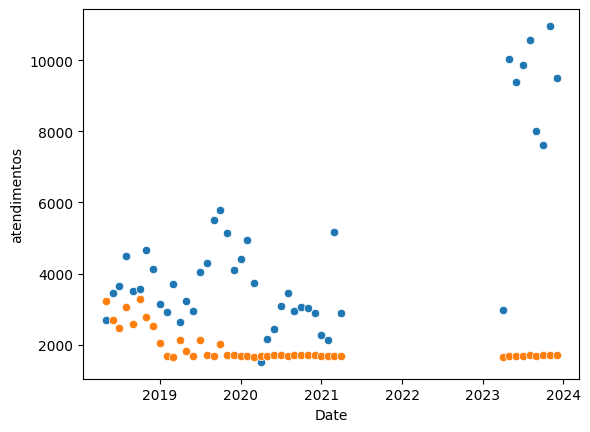

In [108]:
predicted_values = predictor.predict(data.tail(int(len(data)/2)))


sns.scatterplot(data.tail(int(len(data)/2)), x="Date", y="atendimentos")
sns.scatterplot(data.tail(int(len(data)/2)), x="Date", y=predicted_values)

In [109]:
predictor.eval_metric(y_pred=predicted_values, y_true=data.tail(4500)["atendimentos"])

-3734.480511927522